# Определение авторства статьи на основе нейронных сетей
### Постановка задачи:
* ......
* ......

**Распоковка датасета**

In [1]:
!unzip -u dataset.zip
print('Success')

Archive:  dataset.zip
Success


In [2]:
!zip -r datasetCSV.zip datasetHabrahabr.csv

  adding: datasetHabrahabr.csv (deflated 76%)


**Импорт пакетов**

In [24]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dropout
import numpy as np
import pandas as pd
import codecs
import os

%matplotlib inline

**Загрузка готового набора данных**

In [2]:
data = pd.read_csv('datasetHabrahabr.csv')
data.head()

,Author,Text,TextLem
0,25,"В шестой части серии учебных материалов, посв...","в шесть часть серия учебный материалов, посвят..."
1,25,С каждым новом поколением процессоры Intel вб...,с каждый новый поколение процессор intel вбира...
2,25,Статья в блоге Intel «Прокачай свой жесткий д...,статья в блог intel «прокачать свой жёсткий ди...
3,25,Испанская компания с говорящим названием Geek...,испанский компания с говорящий название geeksp...
4,25,igzip — высокопроизводительная библиотека для...,igzip — высокопроизводительный библиотека для ...


**Загрузка тестовых документов**

In [2]:
def get_dataset_from_files():
    #path = 'D:\Разработка\DataScience\Habrahabr'
    path = 'Habrahabr/'
    files = os.listdir(path)
    data_frame = pd.DataFrame()

    for file_name in files:
        file_obj = codecs.open(path + file_name, "r", "utf_8_sig" )
        file_temp = file_obj.read()
        url = file_temp[file_temp.find('url:') + 5:file_temp.find('title:')].rstrip()
        title = file_temp[file_temp.find('title:') + 7:file_temp.find('text:')].rstrip()
        text = file_temp[file_temp.find('text:') + 5:file_temp.find('author:')].rstrip()
        author = file_temp[file_temp.find('author:') + 8:].rstrip()
        row = pd.Series([url, title, text, author], index=['Url', 'Title', 'Text', 'Author'])
        data_frame = data_frame.append(row, ignore_index=True)
        file_obj.close()
        
    return data_frame

In [ ]:
data_frame = get_dataset_from_files()

**Подсчет количества слов в каждой статье**

In [14]:
data_frame['CountWords'] = data_frame['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data_frame))
data_frame.head()

Количество статей в корпусе: 4335


,Author,Text,Title,Url,CountWords
0,@tangro,Многие языки программирования включают в себя...,"Чем меньше, тем лучше — о возможностях языков ...",https://habrahabr.ru/company/infopulse/blog/30...,2368
1,@saul,"В шестой части серии учебных материалов, посв...","Расширения Intel Software Guard Extensions, уч...",https://habrahabr.ru/company/intel/blog/323626/,2260
2,@Andrey2008,Подобная статья уже публиковалась на нашем са...,"Open-source проекты, которые мы проверили с по...",https://habrahabr.ru/company/pvs-studio/blog/2...,496
3,@vasyay,Недавно от коллег из Callbackhunter мне попал...,Проверка устойчивости бизнес-модели с помощью ...,https://habrahabr.ru/company/twins/blog/289004/,945
4,@alexzfort,Предлагаем вашему вниманию подборку с ссылкам...,Дайджест интересных материалов из мира веб-раз...,https://habrahabr.ru/company/zfort/blog/248177/,1060


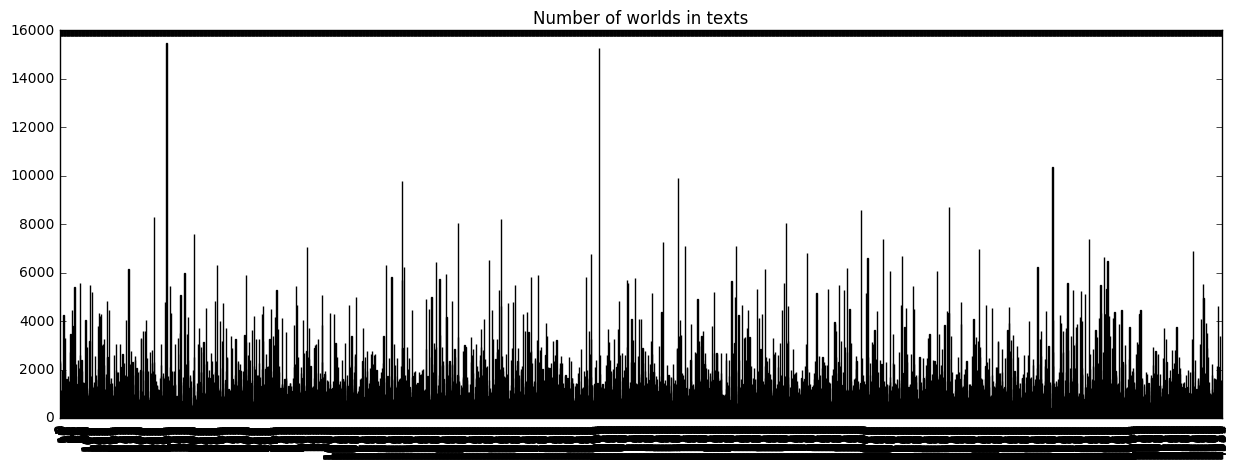

In [5]:
data_frame.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts")

**Количество статей у каждого пользователя**

In [4]:
num_classes = 29

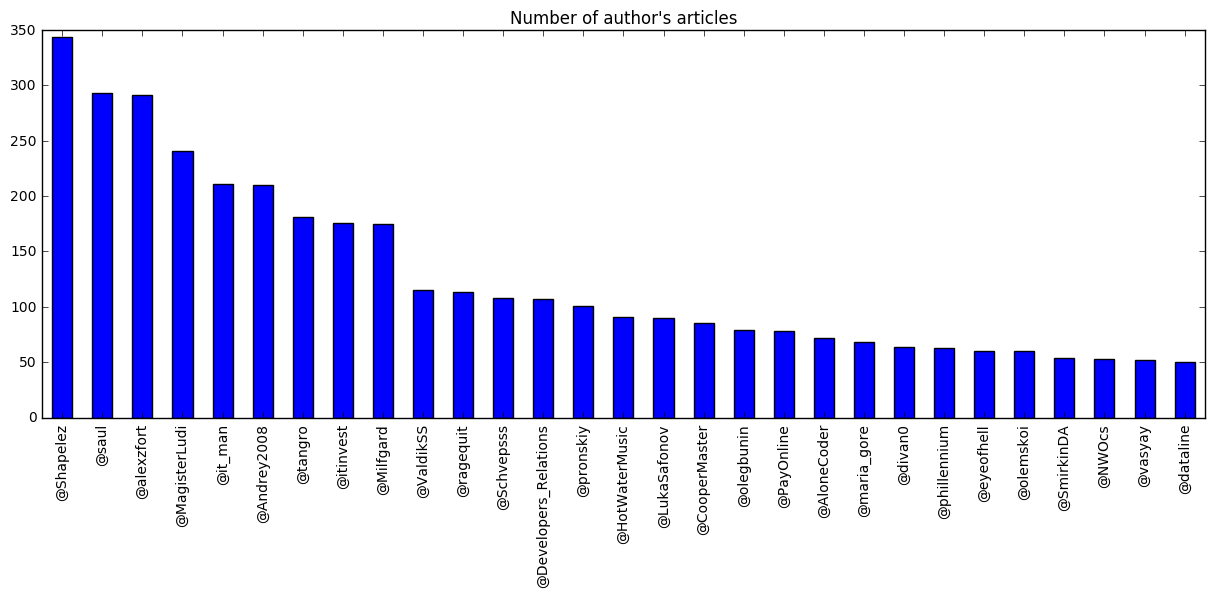

In [4]:
author_count_news = data_frame.Author.value_counts()[:num_classes]
author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles")

### Подготовка данных для анализа
- Добавление только топ 30 авторов
- Удаление стоп слов
- Лемматизация текста
- Удаление лишних столбцов
- One hot encoding для авторов

In [5]:
data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    data = data.append(data_frame[data_frame.Author == author])

print('Количество статей после удаления:', len(data))

Количество статей после удаления: 3685


In [20]:
from nltk.corpus import stopwords
stop = stopwords.words('russian')
data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
print('Stop words have been deleted')

Stop words have been deleted


In [22]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
print('The lemmatization completed')

The lemmatization completed


In [8]:
names = data.Author.value_counts().index.values

lableEnc = LabelEncoder()
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((num_classes, 1))

oneHotEnc = OneHotEncoder()
oneHotEnc.fit(lables)

#lableEnc.fit(names_author.ravel()) 
#lables = lableEnc.transform(names_author).reshape((29, 1))
#oneHotEnc.fit(lables)

# Example encoding
#aaa = lableEnc.transform(['@saul'])
#vvv = oneHotEnc.transform(aaa).toarray()
#print(vvv)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [9]:
for author in names:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

#data = data.drop(['Url', 'Title', 'CountWords'], axis=1)
data.head()

,Author,Text,TextLem
0,25,"В шестой части серии учебных материалов, посв...","в шесть часть серия учебный материалов, посвят..."
1,25,С каждым новом поколением процессоры Intel вб...,с каждый новый поколение процессор intel вбира...
2,25,Статья в блоге Intel «Прокачай свой жесткий д...,статья в блог intel «прокачать свой жёсткий ди...
3,25,Испанская компания с говорящим названием Geek...,испанский компания с говорящий название geeksp...
4,25,igzip — высокопроизводительная библиотека для...,igzip — высокопроизводительный библиотека для ...


**Сохранение датасета**

In [28]:
filename = 'datasetHabrahabr.csv'
data.to_csv(filename, index=False, encoding='utf-8')

**Перемешивание набора данных**

In [10]:
data = data.sample(frac=1).reset_index(drop=True)

**Токенизация текста**

In [11]:
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r'
max_features = 50000

In [7]:
def get_texts_to_matrix(text, max_features = 0):
    tokenizer = Tokenizer(filters=filters, split=" ", lower=True)
    
    if max_features != 0:
        tokenizer = Tokenizer(filters=filters, split=" ", lower=True, num_words=max_features)
    
    tokenizer.fit_on_texts(text)
    matrix_tfidf = tokenizer.texts_to_matrix(texts=text, mode='tfidf')
    print('Количество текстов:', matrix_tfidf.shape[0])
    print('Количество токенов:', matrix_tfidf.shape[1])
    return matrix_tfidf

In [12]:
def get_texts_to_sequences(text):
    # создаем единый словарь (слово -> число) для преобразования
    tokenizer = Tokenizer(split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    # Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
    text_sequences = tokenizer.texts_to_sequences(text)
    total_words = len(tokenizer.word_index)
    print('В словаре {} слов'.format(total_words))
    return text_sequences

In [7]:
def get_texts_to_gramm_sequences(texts, count_gramm = 3):
    gramms = {}
    counter_gramm = 0
    result = []
    temp_vector = []
    
    for text in texts:
        for i in range(len(text) - count_gramm - 1):
            gramm = text[i : i + count_gramm]
            if gramms.get(gramm) == None:
                gramms[gramm] = counter_gramm
                counter_gramm += 1
            temp_vector.append(gramms[gramm])
        result.append(temp_vector)
        temp_vector = []
        
    print('Количество грамм в корпусе:', len(gramms))
    return result

In [25]:
matrix_tfidf = get_texts_to_matrix(data['TextLem'], max_features=max_features)

Количество текстов: 3381
Количество токенов: 50000


In [13]:
text_sequences = get_texts_to_sequences(data['Text'])

В словаре 270878 слов


In [8]:
text_threegramm = get_texts_to_gramm_sequences(data['Text'])

Количество грамм в корпусе: 208044


In [42]:
count_gramm = [len(x) for x in text_threegramm]

num = np.array(count_gramm)
num.mean()

9765.6320615202603

### Разбиваем выборку на тестовую и тренировочную

In [14]:
def load_data_from_arrays(strings, labels, train_test_split=0.9):
    data_size = len(strings)
    test_size = int(data_size - round(data_size * train_test_split))
    print("Test size: {}".format(test_size))
    
    print("\nTraining set:")
    x_train = strings[test_size:]
    print("\t - x_train: {}".format(len(x_train)))
    y_train = labels[test_size:]
    print("\t - y_train: {}".format(len(y_train)))
    
    print("\nTesting set:")
    x_test = strings[:test_size]
    print("\t - x_test: {}".format(len(x_test)))
    y_test = labels[:test_size]
    print("\t - y_test: {}".format(len(y_test)))

    return x_train, y_train, x_test, y_test

In [15]:
X_train, y_train, X_test, y_test = load_data_from_arrays(text_sequences, data.Author, train_test_split=0.8)

Test size: 676

Training set:
	 - x_train: 2705
	 - y_train: 2705

Testing set:
	 - x_test: 676
	 - y_test: 676


In [16]:
import keras

# количество наиболее часто используемых слов
# Максимальное количество слов в самом длинном описании заявки
num_words = 4000
#num_words = 9765

print(u'Преобразуем описания заявок в векторы чисел...')
tokenizer = Tokenizer(num_words=num_words)
#X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
#X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')
# Заполняем или обрезаем рецензии
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=num_words)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=num_words)
print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)

print(u'Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Преобразуем описания заявок в векторы чисел...
Размерность X_train: (2705, 4000)
Размерность X_test: (676, 4000)
Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)
y_train shape: (2705, 29)
y_test shape: (676, 29)


In [23]:
#X = matrix_tfidf
#y = oneHotEnc.transform(data.Author.values.reshape(-1, 1)).toarray()

### Создание модели нейронной сети

In [29]:
max_features = 100000

def get_lstm_model():    
    model = Sequential()
    # Слой для векторного представления слов
    model.add(Embedding(max_features, 500))
    model.add(SpatialDropout1D(0.3))
    # Слой долго-краткосрочной памяти
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3)) 
    # Полносвязный слой
    model.add(Dense(num_classes, activation="sigmoid"))
    # Копмилируем модель
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #SGD
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def get_conv_model():
    model = Sequential()
    model.add(Embedding(270878, 300, input_length=num_words))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(num_classes, activation="sigmoid"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = get_conv_model()
history = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.1)
#model.fit(X, y, batch_size=15, epochs=2, shuffle=True, validation_split=0.2)
#model.fit(X, y, batch_size=64, epochs=3, verbose=2, shuffle=True, validation_split=0.2)
# Проверяем качество обучения на тестовых данных
#scores = model.evaluate(X, y, batch_size=1000)
#print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

Train on 2434 samples, validate on 271 samples
Epoch 1/20
2434/2434 [==============================] - 46s - loss: 3.2471 - acc: 0.1401 - val_loss: 3.0673 - val_acc: 0.3100

In [55]:
print('Точность модели составляет: {}'.format(model.evaluate(X_test, y_test, batch_size=20)[1] * 100))

676/676 [==============================] - 95s     

In [56]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("model/habra_model_4_threegramm.json", "w")
json_file.write(model_json)
json_file.close()

model.save_weights("model/habra_model_weights_4_threegramm.h5")